In [1]:
import sys
sys.path.insert(0, 'visualization.py')
sys.path.insert(0, 'utils.py')

In [2]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2024-11-23 13:10:58,650 - utils - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [3]:
n_frame = 0
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(10, 8)


# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [4]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

(51, 8)


# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

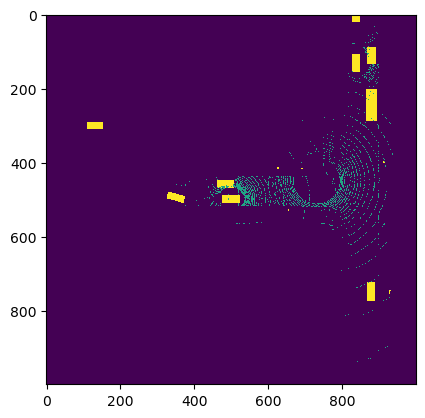

In [7]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  ------------------  
box_mask = box_to_pixels(irsu_boxes[:,:7], bev_imsize, bev_resolution)
bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
   bev_occupancy[pixel[1], pixel[0]] = 150


plt.imshow(bev_occupancy)


# Task n°4: 
Segment points according to object's class

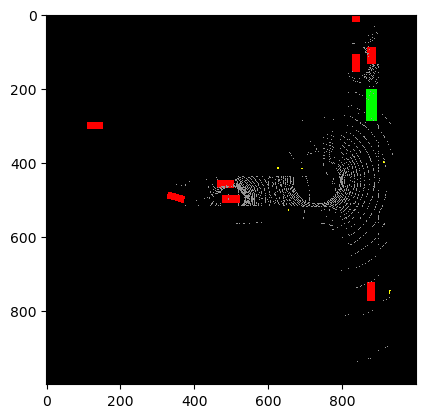

In [19]:
# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)

# Define the class colors
CLASS_COLORS = {
    0.0: [255, 0, 0],    # Red for class 0 - Cars?
    1.0: [0, 255, 0],    # Green for class 1 - Maybe its a truck?
    2.0: [0, 0, 255],    # Blue for class 2 - Cyclist?
    3.0: [255, 255, 0],  # Yellow for class 3 - Traffic lights?
    # Add other classes as needed
}

# ------------------  Initialize BEV RGB Image ------------------  
bev_rgb_image = np.zeros((bev_imsize[1], bev_imsize[0], 3), dtype=np.uint8)

# ------------------  Project bbox of actors on the image ------------------  
for i, box in enumerate(irsu_boxes):
    class_label = float(box[-1])  # Extract the class label
    color = CLASS_COLORS.get(class_label, [255, 255, 255])  # Default to white if class not found

    # Create a mask for the current box
    single_box_mask = box_to_pixels(box[:7].reshape(1, 7), bev_imsize, bev_resolution)

    # Apply the color to the corresponding pixels in the BEV image
    for c in range(3):  # Iterate over RGB channels
        bev_rgb_image[:, :, c] = np.where(single_box_mask > 0, color[c], bev_rgb_image[:, :, c])

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

# Apply a specific color for navigable space (e.g., gray)
for pixel in navigable_space:
    bev_rgb_image[pixel[1], pixel[0], :] = [150, 150, 150]  # Gray for navigable space

# ------------------  Display the BEV Image ------------------  
plt.imshow(bev_rgb_image)
plt.show()